In [15]:
# Install pylibCZIrw and dependencies
#! pip install --upgrade pip
#! pip install "pylibCZIrw~=4.0" "cztile>=0.0,<1.0" matplotlib tqdm scikit-image pooch requests

In [1]:
from pylibCZIrw import czi as pyczi
import json
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from numpy import ma
import os, sys
from tqdm import tqdm
from tqdm.contrib import itertools as it
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from cellpose import utils
import cv2
from scipy import ndimage
from pathlib import Path
import pandas as pd
import shapely
from rasterio.features import rasterize
from skimage import exposure
from PIL import Image

# show the used python env
print("Using:", sys.executable)

/Users/chrism/opt/miniconda3/envs/cellpose/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using: /Users/chrism/opt/miniconda3/envs/cellpose/bin/python


The **`total_bounding_rectangle`** gives us the X and Y dimensions of the CZI, i.e. the (X, Y) of the **`total_bounding_box`**.

Text(0.5, 1.0, 'DAPI masked')

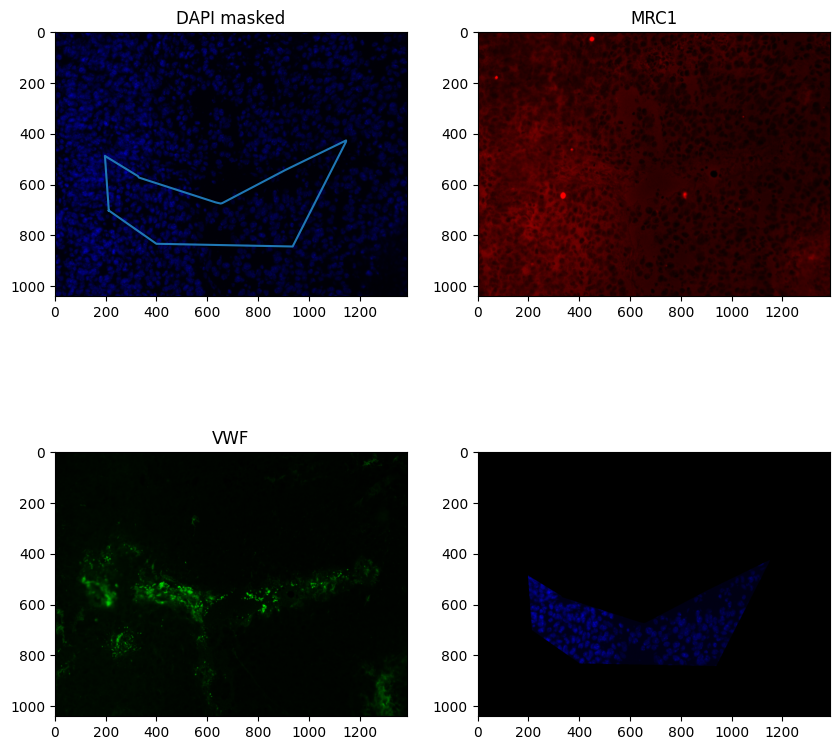

In [5]:
czifile = "Snap-147447.czi"

colors_blue = [(0, 0, 0), (0, 0, 1)]
cm_blue = LinearSegmentedColormap.from_list("Custom", colors_blue, N=255)

colors_red = [(0, 0, 0), (1, 0, 0)]
cm_red = LinearSegmentedColormap.from_list("Custom", colors_red, N=255)

colors_green = [(0, 0, 0), (0, 1, 0)] 
cm_green = LinearSegmentedColormap.from_list("Custom", colors_green, N=255)

colors_white = [(0, 0, 0), (1, 1, 1)] 
cm_white = LinearSegmentedColormap.from_list("Custom", colors_white, N=255)

with pyczi.open_czi(czifile) as czidoc:
    ch0 = czidoc.read(plane={'C': 0})
    dapi = ch0[..., 0]
    ch1 = czidoc.read(plane={'C': 1})
    mrc1 = ch1[..., 0]
    ch2 = czidoc.read(plane={'C': 2})
    vwf = ch2[..., 0]
    meta = czidoc.metadata
roi = meta['ImageDocument']['Metadata']['Layers']['Layer']['Elements']['Polygon']
points = roi['Geometry']['Points']
coords = []
for point in points.split(" "):
    x, y = point.split(",")
    coords.append((float(x), float(y)))
coords.append(coords[0])
polygon = shapely.Polygon(coords)
mask = rasterize([polygon], out_shape = dapi.shape)

dapi_masked = dapi.copy()
dapi_masked[mask == 0] = 0
dapi_masked_8 = exposure.rescale_intensity(dapi_masked, out_range=np.uint8)
z = np.zeros(dapi_masked_8.shape)
dapi_rgb = np.dstack((z, z, dapi_masked_8)).astype(np.uint8)
img_rgb = Image.fromarray(dapi_rgb)
img_rgb.save("dapi_rgb.png")

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

xs, ys = zip(*coords) #create lists of x and y values
# DAPI
ax[0,0].imshow(dapi, cmap=cm_blue)
ax[0,0].plot(xs, ys)
ax[0,0].set_title("DAPI")

# MRC1
ax[0,1].imshow(mrc1, cmap=cm_red)
ax[0,1].set_title("MRC1")

# VWF
ax[1,0].imshow(vwf, cmap=cm_green)
ax[1,0].set_title("VWF")

# DAPI masked
ax[1,1].imshow(dapi_masked, cmap=cm_blue)
ax[0,0].set_title("DAPI masked")




In [10]:
data_path = Path('.')

for czifile in data_path.glob("dapi nucleus segmentation/*.czi"):
    print(czifile)
    if not czifile.exists():
        print(f"{czifile} does not exist. Skipping ...")
        continue
    with pyczi.open_czi(str(czifile)) as czidoc:
        ch0 = czidoc.read(plane={'C': 0})
        dapi = ch0[..., 0]
        ch1 = czidoc.read(plane={'C': 1})
        mrc1 = ch1[..., 0]
        ch2 = czidoc.read(plane={'C': 2})
        vwf = ch2[..., 0]
        meta = czidoc.metadata
    roi = meta['ImageDocument']['Metadata']['Layers']['Layer']['Elements']['Polygon']
    points = roi['Geometry']['Points']
    coords = []
    for point in points.split(" "):
        x, y = point.split(",")
        coords.append((float(x), float(y)))
    coords.append(coords[0])
    polygon = shapely.Polygon(coords)
    mask = rasterize([polygon], out_shape = dapi.shape)
    
    dapi_masked = dapi.copy()
    dapi_masked[mask == 0] = 0
    dapi_masked_8 = exposure.rescale_intensity(dapi_masked, out_range=np.uint8)
    z = np.zeros(dapi_masked_8.shape)
    dapi_rgb = np.dstack((z, z, dapi_masked_8)).astype(np.uint8)
    img_rgb = Image.fromarray(dapi_rgb)
    # img_rgb.save("dapi_rgb.png")


dapi nucleus segmentation/Snap-157208.czi
dapi nucleus segmentation/Snap-147782.czi
dapi nucleus segmentation/Snap-147781.czi
dapi nucleus segmentation/Snap-147780.czi
dapi nucleus segmentation/Snap-147779.czi
dapi nucleus segmentation/Snap-147454.czi


TypeError: list indices must be integers or slices, not str

In [18]:
npyfile = "Snap-155522_c1+2+3+4_seg.npy"
dat = np.load(npyfile, allow_pickle=True).item()
num_cells = dat["masks"].max()
masks = dat["masks"]
slices = utils.find_objects(masks)
num_cells = len(slices)
for i,si in enumerate(slices):
    if si is not None:
        sr,sc = si
        mask = (masks[sr, sc] == (i+1)).astype(np.uint8)
        contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        pvc, pvr = np.concatenate(contours[-2], axis=0).squeeze().T  
        ypix, xpix = np.nonzero(mask)
        min_dist = ((ypix[:,np.newaxis] - pvr)**2 + 
                    (xpix[:,np.newaxis] - pvc)**2).min(axis=1)
        # dist_to_bound[ypix + sr.start, xpix + sc.start] = min_distfig, ax = plt.subplots()


683.2090495672594 511.7547271373163
67.22332953112806 196.6030977967221
425.7325303715101 243.46542135461743
750.1264078161423 270.5588231960496
719.9003458079228 358.69288355799597
374.6276456486768 367.05393811311234
1281.1087652800152 448.2337471177232
1241.578202888671 501.0068424864727
856.5978107767231 527.52112351896
453.52517144719013 813.7502198040899
374.19252152974286 841.6605394130413
494.75535995477856 911.9884119998385
490.2133114035088 930.093004385965
657.679965450582 992.0833024856387
681.7128304189974 1001.6664128813858
817.0785792368395 818.1154818433369
903.273197351776 887.0858641354029
937.9992611484079 995.9234632261936
1240.9111580418248 852.9808580910491
1296.7642865638504 641.4170241446299
1219.0664795769949 392.8298738855901
228.2223392426119 572.3387815616045
317.60815983226877 965.3461650982496
32.294681165475986 482.2537495456383
604.001500013158 959.8557882086685
997.0478463441813 113.50832243855785


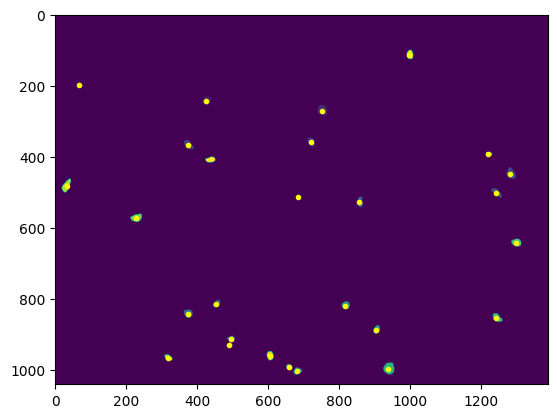

In [19]:
fig, ax = plt.subplots()
ax.imshow(mrc1)
ax.imshow(masks)
cs = ndimage.center_of_mass(mrc1, masks, index=np.arange(0,num_cells))
xs, ys = zip(*cs)
ax.scatter(ys, xs, c="yellow", marker=".")

for y,x in cs:
    print(x,y)


In [20]:
masks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

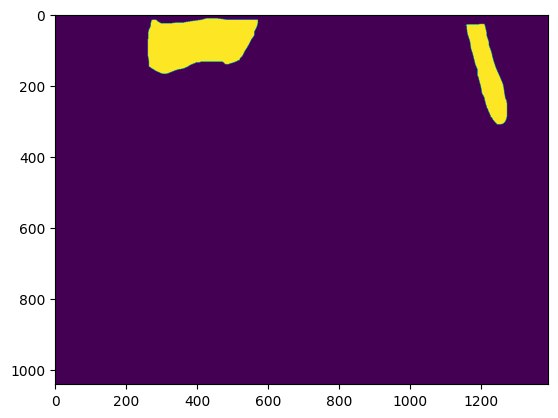

In [21]:
npyfile = "Snap-155522_c1+2+3+4_exclude.npy"
dat = np.load(npyfile, allow_pickle=True).item()
exclude = dat["masks"]>0
plt.imshow(exclude)

Text(0.5, 1.0, 'F4/80')

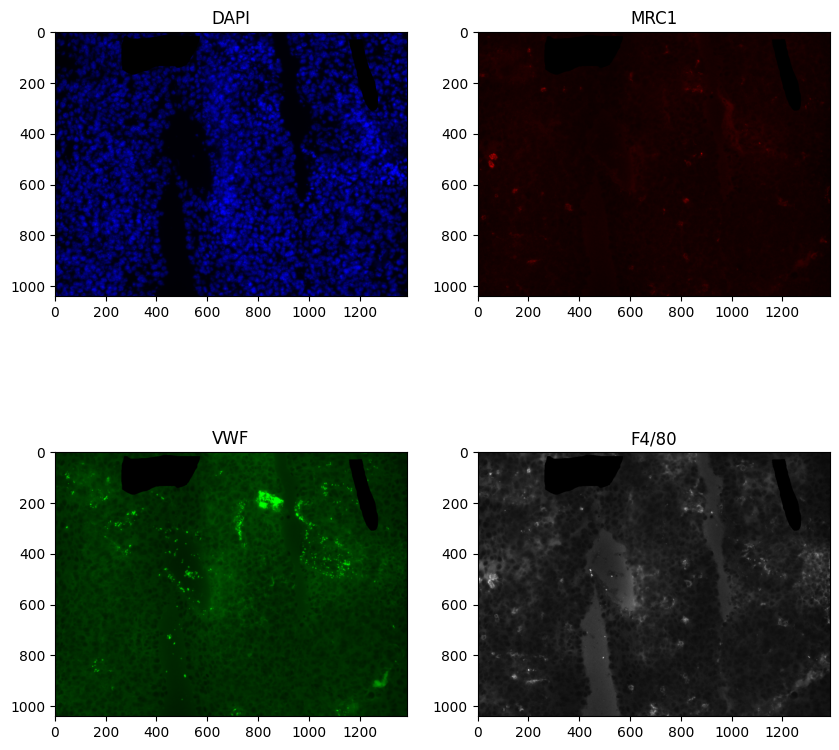

In [22]:
dapi[exclude > 0] = 0
mrc1[exclude > 0] = 0
vwf[exclude > 0] = 0
f480[exclude > 0] = 0

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(dapi, cmap=cm_blue)
ax[0,0].set_title("DAPI")

# MRC1
ax[0,1].imshow(mrc1, cmap=cm_red)
ax[0,1].set_title("MRC1")

# VWF
ax[1,0].imshow(vwf, cmap=cm_green)
ax[1,0].set_title("VWF")

# F4/80
ax[1,1].imshow(f480, cmap=cm_white)
ax[1,1].set_title("F4/80")

In [23]:
slices = utils.find_objects(masks)

for i,si in enumerate(slices):
    if np.any((masks == i+1) & exclude):
        print(f"Cell {i+1} intersecting exclude region. Skipping ...")
        continue
    if si is not None:
        sr,sc = si
        mask = masks[sr, sc] != (i+1)
        dapi_ma = ma.masked_array(dapi[sr, sc], mask)
        mrc1_ma = ma.masked_array(mrc1[sr, sc], mask)
        vwf_ma = ma.masked_array(vwf[sr, sc], mask)
        f480_ma = ma.masked_array(f480[sr, sc], mask)
        mrc1_f480_ratio = mrc1_ma.sum() / f480_ma.sum()
        print(f"MRC1 F4/80 ratio = {mrc1_f480_ratio}")

MRC1 F4/80 ratio = 0.6493602688352292
MRC1 F4/80 ratio = 0.7285401523776163
MRC1 F4/80 ratio = 1.1271164066226067
MRC1 F4/80 ratio = 0.9073466554136833
MRC1 F4/80 ratio = 0.7863334780182303
MRC1 F4/80 ratio = 0.4615633583512658
MRC1 F4/80 ratio = 0.7684273937441478
MRC1 F4/80 ratio = 0.8047161494410408
MRC1 F4/80 ratio = 0.39971802218611363
MRC1 F4/80 ratio = 0.7609014045058555
MRC1 F4/80 ratio = 0.38177670217193593
MRC1 F4/80 ratio = 0.3829583532790809
MRC1 F4/80 ratio = 0.7494759556103576
MRC1 F4/80 ratio = 0.4707804326060039
MRC1 F4/80 ratio = 1.0518032786885245
MRC1 F4/80 ratio = 0.9070571878454889
MRC1 F4/80 ratio = 0.8400467550307342
MRC1 F4/80 ratio = 0.7896604473868993
MRC1 F4/80 ratio = 0.7938651156349537
MRC1 F4/80 ratio = 0.6731673040593467
MRC1 F4/80 ratio = 0.6857034819209145
MRC1 F4/80 ratio = 0.8655229895971809
MRC1 F4/80 ratio = 0.4001748230358578
MRC1 F4/80 ratio = 0.8030643513789582
MRC1 F4/80 ratio = 0.86712621639923
MRC1 F4/80 ratio = 0.5023363820269539


Text(0.5, 1.0, 'F4/80')

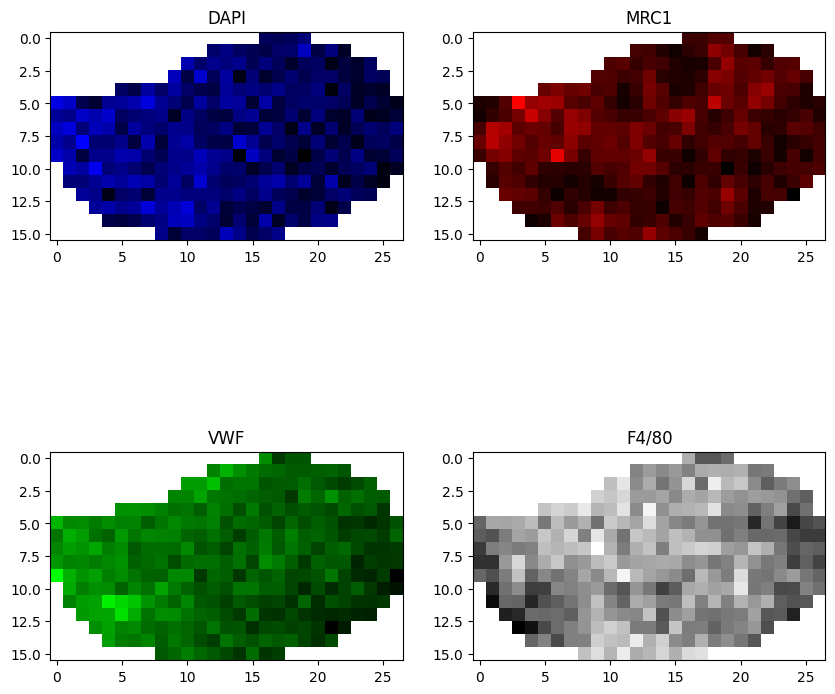

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(dapi_ma, cmap=cm_blue)
ax[0,0].set_title("DAPI")

# MRC1
ax[0,1].imshow(mrc1_ma, cmap=cm_red)
ax[0,1].set_title("MRC1")

# VWF
ax[1,0].imshow(vwf_ma, cmap=cm_green)
ax[1,0].set_title("VWF")

# F4/80
ax[1,1].imshow(f480_ma, cmap=cm_white)
ax[1,1].set_title("F4/80")

In [25]:
radius = 35
x_axis = np.linspace(-1, 1, 2*radius+1)[:, None]
y_axis = np.linspace(-1, 1, 2*radius+1)[None, :]
arr = np.sqrt(x_axis ** 2 + y_axis ** 2)
weights = (arr - arr.max()) * -1

cs = ndimage.center_of_mass(mrc1, masks, index=np.arange(0,num_cells))
# xs, ys = zip(*cs)
for y,x in cs:
    print(x,y)
    x = round(x)
    y = round(y)
    sr = slice(y-radius, y+radius+1)
    sc = slice(x-radius, x+radius+1)
    region = vwf[sr, sc]
    vwf_mean = np.average(region, weights=weights)
    print(vwf_mean)
    


683.7812004510539 524.5410193001056
1066.6386120611128
67.22332953112806 196.6030977967221
811.3360687113172
425.7325303715101 243.46542135461743
619.776960055118
750.1264078161423 270.5588231960496
1200.1081284674967
719.9003458079228 358.69288355799597
1060.918086950851
374.6276456486768 367.05393811311234
639.2658144846772
1281.1087652800152 448.2337471177232
879.8376069548251
1241.578202888671 501.0068424864727
834.0155274937225
856.5978107767231 527.52112351896
775.2163116004334
453.52517144719013 813.7502198040899
637.652852769542
374.19252152974286 841.6605394130413
699.6328281065669
494.75535995477856 911.9884119998385
606.9374967495559
490.2133114035088 930.093004385965
563.0255643961023
657.679965450582 992.0833024856387
688.0416094545254
681.7128304189974 1001.6664128813858
788.4800289980751
817.0785792368395 818.1154818433369
677.8166283573954
903.273197351776 887.0858641354029
678.6806958040486
937.9992611484079 995.9234632261936
676.0850497754349
1240.9111580418248 852.98

TypeError: Axis must be specified when shapes of a and weights differ.

In [ ]:
# load czi
# load cell masks
# load exclude masks
# mask czi channels with exclude masks (set 0)
# discard cells intersecting exclude masks

In [ ]:
vwf_ma.sum()

In [43]:
data_path = Path('C:\\Users\\chrism\\tmp\\mina_231020\\Makro')
area_pixel = 0.512 * 0.512
cells_path = data_path / "Cells"
czi_path = data_path / "CZI"
exclude_path = data_path / "Exclude"
debug_path = data_path / "debug"
list_radius = [20, 30, 40, 50, 70, 100, 150, 200, 250]
radius = 100
debug = False

colors_blue = [(0, 0, 0), (0, 0, 1)]
cm_blue = LinearSegmentedColormap.from_list("Custom", colors_blue, N=255)

colors_red = [(0, 0, 0), (1, 0, 0)]
cm_red = LinearSegmentedColormap.from_list("Custom", colors_red, N=255)

colors_green = [(0, 0, 0), (0, 1, 0)] 
cm_green = LinearSegmentedColormap.from_list("Custom", colors_green, N=255)

colors_white = [(0, 0, 0), (1, 1, 1)] 
cm_white = LinearSegmentedColormap.from_list("Custom", colors_white, N=255)

for radius in list_radius:
    results = []
    x_axis = np.linspace(-1, 1, 2*radius+1)[:, None]
    y_axis = np.linspace(-1, 1, 2*radius+1)[None, :]
    arr = np.sqrt(x_axis ** 2 + y_axis ** 2)
    weights = (arr - arr.max()) * -1
    for cell_masks_file in cells_path.glob("**/*.npy"):
        print(cell_masks_file)
        slide = cell_masks_file.parent.parts[-1]
        group = cell_masks_file.parent.parts[-2]
        
        exclude_masks = exclude_path / group / slide / cell_masks_file.name
        if not exclude_masks.exists():
            print(f"{exclude_masks} does not exist. Skipping ...")
            continue
            
        czi_file_name = cell_masks_file.name.split('_')[0] + '.czi'
        czi_file = czi_path / group / slide / czi_file_name
        if not czi_file.exists():
            print(f"{czi_file} does not exist. Skipping ...")
            continue

        cell_seg = np.load(cell_masks_file, allow_pickle=True).item()
        cell_masks = cell_seg["masks"]
        num_cells = cell_masks.max()
        
        exclude_seg = np.load(exclude_masks, allow_pickle=True).item()
        exclude_masks = exclude_seg["masks"] > 0
        
        num_pixels = exclude_masks.shape[0] * exclude_masks.shape[1] - np.count_nonzero(exclude_masks)
        area = num_pixels * area_pixel
        # print(area)
        cells_per_um2 = num_cells / area
        # print(cells_per_um2)

        with pyczi.open_czi(str(czi_file)) as czidoc:
            ch0 = czidoc.read(plane={'C': 0})
            dapi = ch0[..., 0]
            ch1 = czidoc.read(plane={'C': 1})
            mrc1 = ch1[..., 0]
            ch2 = czidoc.read(plane={'C': 2})
            vwf = ch2[..., 0]
            ch3 = czidoc.read(plane={'C': 3})
            f480 = ch3[..., 0]

        if debug:
            # d_slices = utils.find_objects(masks)
            # d_mrc1 = mrc1.copy()
            # for i,si in enumerate(slices):
            #     if si is not None:
            #         sr,sc = si
            #         mask = (masks[sr, sc] == (i+1)).astype(np.uint8)
            #         contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            #         ax.contours(
            #         d_mrc1 = cv2.drawContours(d_mrc1, contours, -1, (0, 255, 0), 2)
                    
            plt.ioff()
            fig, ax = plt.subplots(figsize=(13, 10))
            ax.imshow(mrc1, cmap=cm_red)
       
        slices = utils.find_objects(cell_masks)
        cell_centers = ndimage.center_of_mass(mrc1, cell_masks, index=np.arange(1, num_cells + 1))

        for i, (si, (row, col)) in enumerate(zip(slices, cell_centers)): 
            if np.any((cell_masks == i+1) & exclude_masks):
                print(f"Cell {i+1} intersecting exclude region. Skipping ...")
                continue
            if si is not None:
                sr, sc = si
                mask = cell_masks[sr, sc] != (i+1)
                dapi_ma = ma.masked_array(dapi[sr, sc], mask)
                mrc1_ma = ma.masked_array(mrc1[sr, sc], mask)
                vwf_ma = ma.masked_array(vwf[sr, sc], mask)
                f480_ma = ma.masked_array(f480[sr, sc], mask)
                mrc1_f480_ratio = mrc1_ma.sum() / f480_ma.sum()
                f480_mrc1_ratio = f480_ma.sum() / mrc1_ma.sum()
                # print(f"MRC1 F4/80 ratio = {mrc1_f480_ratio}")
            
            corrected_weights = weights
            # print(row, col)
            row = round(row)
            col = round(col)
            
            if row - radius < 0:
                row_start = 0
                corrected_weights = corrected_weights[radius - row:, :]
            else:
                row_start = row - radius

            if row + radius > 1039:
                row_end = 1039
                corrected_weights = corrected_weights[:-1 * ((row + radius + 1) - 1039), :]
            else:
                row_end = row + radius + 1

            if col - radius < 0:
                col_start = 0
                corrected_weights = corrected_weights[:, radius - col:]
            else:
                col_start = col - radius

            if col + radius > 1387:
                col_end = 1387
                corrected_weights = corrected_weights[:, :-1 * ((col + radius + 1) - 1387)]
            else:
                col_end = col + radius + 1
            
            region = vwf[row_start:row_end, col_start:col_end]
            vwf_mean = np.average(region, weights=corrected_weights)
            # print(vwf_mean)

            results_row = {'group': group, 'slide': slide, 'czi': czi_file_name, 'cell_no': i, 'mrc1/f480': mrc1_f480_ratio, 'f480/mrc1': f480_mrc1_ratio, 'mean(vwf)': vwf_mean}
            results.append(results_row)

            if debug:
                ax.text(col, row, str(i), color="white")
                ax.scatter(col, row, c="yellow", marker=".")
                # d_mask = (cell_masks[sr, sc] == (i+1)).astype(np.uint8)
                # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
                # d_contour = d_contours[0]
                
                # M = cv2.moments(d_contour)
                # x = int(M["m10"] / M["m00"])
                # y = int(M["m01"] / M["m00"])
                
                # xs = [v[0][0] - x for v in d_contour]
                # ys = [-(v[0][1] - y) for v in d_contour]
                
                # ax.plot(xs, ys, color="green")
                

        if debug:
            debug_file_name = cell_masks_file.name + ".png"
            debug_file = debug_path / group / slide / debug_file_name
            debug_file.parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(str(debug_file))
            plt.close(fig)
            plt.ion()
            
    df = pd.DataFrame(results)
    out_fn = f"results_radius={radius}.xlsx"
    df.to_excel(data_path / out_fn)

C:\Users\chrism\tmp\mina_231020\Makro\Cells\EX\Makro 1601 EX\Snap-148130P_c1+2+4_seg.npy
C:\Users\chrism\tmp\mina_231020\Makro\Cells\EX\Makro 1601 EX\Snap-148534_c1+2+4_seg.npy
C:\Users\chrism\tmp\mina_231020\Makro\Cells\EX\Makro 1601 EX\Snap-148535_c1+2+4_seg.npy
C:\Users\chrism\tmp\mina_231020\Makro\Cells\EX\Makro 1601 EX\Snap-148536_c1+2+4_seg.npy
C:\Users\chrism\tmp\mina_231020\Makro\Cells\EX\Makro 1601 EX\Snap-148537_c1+2+4_seg.npy
C:\Users\chrism\tmp\mina_231020\Makro\Cells\EX\Makro 1696 EX\Snap-148478_c1+2+4_seg.npy
C:\Users\chrism\tmp\mina_231020\Makro\Cells\EX\Makro 1696 EX\Snap-148482_c1+2+4_seg.npy
C:\Users\chrism\tmp\mina_231020\Makro\Cells\EX\Makro 1696 EX\Snap-148485_c1+2+4_seg.npy
C:\Users\chrism\tmp\mina_231020\Makro\Cells\EX\Makro 1760 EX\Snap-148125_c1+2+4_seg.npy
C:\Users\chrism\tmp\mina_231020\Makro\Cells\EX\Makro 1760 EX\Snap-148129_c1+2+4_seg.npy
C:\Users\chrism\tmp\mina_231020\Makro\Cells\EX\Makro 1760 EX\Snap-148131_c1+2+4_seg.npy
C:\Users\chrism\tmp\mina_231020

In [45]:
data_path = Path('C:\\Users\\chrism\\tmp\\mina_231020\\LY6G')
area_pixel = 0.512 * 0.512
cells_path = data_path / "Cells"
czi_path = data_path / "CZI"
exclude_path = data_path / "Exclude"
debug_path = data_path / "debug"
list_radius = [20, 30, 40, 50, 70, 100, 150, 200, 250]
radius = 100
debug = False

colors_blue = [(0, 0, 0), (0, 0, 1)]
cm_blue = LinearSegmentedColormap.from_list("Custom", colors_blue, N=255)

colors_red = [(0, 0, 0), (1, 0, 0)]
cm_red = LinearSegmentedColormap.from_list("Custom", colors_red, N=255)

colors_green = [(0, 0, 0), (0, 1, 0)] 
cm_green = LinearSegmentedColormap.from_list("Custom", colors_green, N=255)

colors_white = [(0, 0, 0), (1, 1, 1)] 
cm_white = LinearSegmentedColormap.from_list("Custom", colors_white, N=255)

for radius in list_radius:
    results = []
    x_axis = np.linspace(-1, 1, 2*radius+1)[:, None]
    y_axis = np.linspace(-1, 1, 2*radius+1)[None, :]
    arr = np.sqrt(x_axis ** 2 + y_axis ** 2)
    weights = (arr - arr.max()) * -1
    for cell_masks_file in cells_path.glob("**/*.npy"):
        print(cell_masks_file)
        slide = cell_masks_file.parent.parts[-1]
        group = cell_masks_file.parent.parts[-2]
        
        exclude_masks = exclude_path / group / slide / cell_masks_file.name
        if not exclude_masks.exists():
            print(f"{exclude_masks} does not exist. Skipping ...")
            continue
            
        czi_file_name = cell_masks_file.name.split('_')[0] + '.czi'
        czi_file = czi_path / group / slide / czi_file_name
        if not czi_file.exists():
            print(f"{czi_file} does not exist. Skipping ...")
            continue

        cell_seg = np.load(cell_masks_file, allow_pickle=True).item()
        cell_masks = cell_seg["masks"]
        num_cells = cell_masks.max()
        
        exclude_seg = np.load(exclude_masks, allow_pickle=True).item()
        exclude_masks = exclude_seg["masks"] > 0
        
        num_pixels = exclude_masks.shape[0] * exclude_masks.shape[1] - np.count_nonzero(exclude_masks)
        area = num_pixels * area_pixel
        # print(area)
        cells_per_um2 = num_cells / area
        # print(cells_per_um2)

        with pyczi.open_czi(str(czi_file)) as czidoc:
            ch0 = czidoc.read(plane={'C': 0})
            dapi = ch0[..., 0]
            ch1 = czidoc.read(plane={'C': 1})
            ly6g = ch1[..., 0]
            ch2 = czidoc.read(plane={'C': 2})
            vwf = ch2[..., 0]

        if debug:
            # d_slices = utils.find_objects(masks)
            # d_mrc1 = mrc1.copy()
            # for i,si in enumerate(slices):
            #     if si is not None:
            #         sr,sc = si
            #         mask = (masks[sr, sc] == (i+1)).astype(np.uint8)
            #         contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            #         ax.contours(
            #         d_mrc1 = cv2.drawContours(d_mrc1, contours, -1, (0, 255, 0), 2)
                    
            plt.ioff()
            fig, ax = plt.subplots(figsize=(13, 10))
            ax.imshow(mrc1, cmap=cm_red)
       
        slices = utils.find_objects(cell_masks)
        cell_centers = ndimage.center_of_mass(ly6g, cell_masks, index=np.arange(1, num_cells + 1))

        for i, (si, (row, col)) in enumerate(zip(slices, cell_centers)): 
            if np.any((cell_masks == i+1) & exclude_masks):
                print(f"Cell {i+1} intersecting exclude region. Skipping ...")
                continue
            if si is not None:
                sr, sc = si
                mask = cell_masks[sr, sc] != (i+1)
                dapi_ma = ma.masked_array(dapi[sr, sc], mask)
                mrc1_ma = ma.masked_array(ly6g[sr, sc], mask)
                vwf_ma = ma.masked_array(vwf[sr, sc], mask)
            
            corrected_weights = weights
            # print(row, col)
            row = round(row)
            col = round(col)
            
            if row - radius < 0:
                row_start = 0
                corrected_weights = corrected_weights[radius - row:, :]
            else:
                row_start = row - radius

            if row + radius > 1039:
                row_end = 1039
                corrected_weights = corrected_weights[:-1 * ((row + radius + 1) - 1039), :]
            else:
                row_end = row + radius + 1

            if col - radius < 0:
                col_start = 0
                corrected_weights = corrected_weights[:, radius - col:]
            else:
                col_start = col - radius

            if col + radius > 1387:
                col_end = 1387
                corrected_weights = corrected_weights[:, :-1 * ((col + radius + 1) - 1387)]
            else:
                col_end = col + radius + 1
            
            region = vwf[row_start:row_end, col_start:col_end]
            vwf_mean = np.average(region, weights=corrected_weights)
            # print(vwf_mean)

            results_row = {'group': group, 'slide': slide, 'czi': czi_file_name, 'cell_no': i, 'mean(vwf)': vwf_mean}
            results.append(results_row)

            if debug:
                ax.text(col, row, str(i), color="white")
                ax.scatter(col, row, c="yellow", marker=".")
                # d_mask = (cell_masks[sr, sc] == (i+1)).astype(np.uint8)
                # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
                # d_contour = d_contours[0]
                
                # M = cv2.moments(d_contour)
                # x = int(M["m10"] / M["m00"])
                # y = int(M["m01"] / M["m00"])
                
                # xs = [v[0][0] - x for v in d_contour]
                # ys = [-(v[0][1] - y) for v in d_contour]
                
                # ax.plot(xs, ys, color="green")
                

        if debug:
            debug_file_name = cell_masks_file.name + ".png"
            debug_file = debug_path / group / slide / debug_file_name
            debug_file.parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(str(debug_file))
            plt.close(fig)
            plt.ion()
            
    df = pd.DataFrame(results)
    out_fn = f"results_radius={radius}.xlsx"
    df.to_excel(data_path / out_fn)

C:\Users\chrism\tmp\mina_231020\LY6G\Cells\EX\LY6G 1601 EX\Snap-153723_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\LY6G\Cells\EX\LY6G 1601 EX\Snap-153725_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\LY6G\Cells\EX\LY6G 1601 EX\Snap-153727_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\LY6G\Cells\EX\LY6G 1601 EX\Snap-153729_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\LY6G\Cells\EX\LY6G 1601 EX\Snap-153730_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\LY6G\Cells\EX\LY6G 1601 EX\Snap-153731_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\LY6G\Cells\EX\LY6G 1601 EX\Snap-153832_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\LY6G\Cells\EX\LY6G 1696 EX\Snap-153814_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\LY6G\Cells\EX\LY6G 1696 EX\Snap-153816_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\LY6G\Cells\EX\LY6G 1696 EX\Snap-153818_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\LY6G\Cells\EX\LY6G 1696 EX\Snap-153820_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\LY6G\Cells\EX\LY6G 169

In [46]:
data_path = Path('C:\\Users\\chrism\\tmp\\mina_231020\\CD8')
area_pixel = 0.512 * 0.512
cells_path = data_path / "Cells"
czi_path = data_path / "CZI"
exclude_path = data_path / "Exclude"
debug_path = data_path / "debug"
list_radius = [20, 30, 40, 50, 70, 100, 150, 200, 250]
radius = 100
debug = False

colors_blue = [(0, 0, 0), (0, 0, 1)]
cm_blue = LinearSegmentedColormap.from_list("Custom", colors_blue, N=255)

colors_red = [(0, 0, 0), (1, 0, 0)]
cm_red = LinearSegmentedColormap.from_list("Custom", colors_red, N=255)

colors_green = [(0, 0, 0), (0, 1, 0)] 
cm_green = LinearSegmentedColormap.from_list("Custom", colors_green, N=255)

colors_white = [(0, 0, 0), (1, 1, 1)] 
cm_white = LinearSegmentedColormap.from_list("Custom", colors_white, N=255)

for radius in list_radius:
    results = []
    x_axis = np.linspace(-1, 1, 2*radius+1)[:, None]
    y_axis = np.linspace(-1, 1, 2*radius+1)[None, :]
    arr = np.sqrt(x_axis ** 2 + y_axis ** 2)
    weights = (arr - arr.max()) * -1
    for cell_masks_file in cells_path.glob("**/*.npy"):
        print(cell_masks_file)
        slide = cell_masks_file.parent.parts[-1]
        group = cell_masks_file.parent.parts[-2]
        
        exclude_masks = exclude_path / group / slide / cell_masks_file.name
        if not exclude_masks.exists():
            print(f"{exclude_masks} does not exist. Skipping ...")
            continue
            
        czi_file_name = cell_masks_file.name.split('_')[0] + '.czi'
        czi_file = czi_path / group / slide / czi_file_name
        if not czi_file.exists():
            print(f"{czi_file} does not exist. Skipping ...")
            continue

        cell_seg = np.load(cell_masks_file, allow_pickle=True).item()
        cell_masks = cell_seg["masks"]
        num_cells = cell_masks.max()
        
        exclude_seg = np.load(exclude_masks, allow_pickle=True).item()
        exclude_masks = exclude_seg["masks"] > 0
        
        num_pixels = exclude_masks.shape[0] * exclude_masks.shape[1] - np.count_nonzero(exclude_masks)
        area = num_pixels * area_pixel
        # print(area)
        cells_per_um2 = num_cells / area
        # print(cells_per_um2)

        with pyczi.open_czi(str(czi_file)) as czidoc:
            ch0 = czidoc.read(plane={'C': 0})
            dapi = ch0[..., 0]
            ch1 = czidoc.read(plane={'C': 1})
            cd8 = ch1[..., 0]
            ch2 = czidoc.read(plane={'C': 2})
            vwf = ch2[..., 0]

        if debug:
            # d_slices = utils.find_objects(masks)
            # d_mrc1 = mrc1.copy()
            # for i,si in enumerate(slices):
            #     if si is not None:
            #         sr,sc = si
            #         mask = (masks[sr, sc] == (i+1)).astype(np.uint8)
            #         contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            #         ax.contours(
            #         d_mrc1 = cv2.drawContours(d_mrc1, contours, -1, (0, 255, 0), 2)
                    
            plt.ioff()
            fig, ax = plt.subplots(figsize=(13, 10))
            ax.imshow(mrc1, cmap=cm_red)
       
        slices = utils.find_objects(cell_masks)
        cell_centers = ndimage.center_of_mass(cd8, cell_masks, index=np.arange(1, num_cells + 1))

        for i, (si, (row, col)) in enumerate(zip(slices, cell_centers)): 
            if np.any((cell_masks == i+1) & exclude_masks):
                print(f"Cell {i+1} intersecting exclude region. Skipping ...")
                continue
            if si is not None:
                sr, sc = si
                mask = cell_masks[sr, sc] != (i+1)
                dapi_ma = ma.masked_array(dapi[sr, sc], mask)
                mrc1_ma = ma.masked_array(cd8[sr, sc], mask)
                vwf_ma = ma.masked_array(vwf[sr, sc], mask)
            
            corrected_weights = weights
            # print(row, col)
            row = round(row)
            col = round(col)
            
            if row - radius < 0:
                row_start = 0
                corrected_weights = corrected_weights[radius - row:, :]
            else:
                row_start = row - radius

            if row + radius > 1039:
                row_end = 1039
                corrected_weights = corrected_weights[:-1 * ((row + radius + 1) - 1039), :]
            else:
                row_end = row + radius + 1

            if col - radius < 0:
                col_start = 0
                corrected_weights = corrected_weights[:, radius - col:]
            else:
                col_start = col - radius

            if col + radius > 1387:
                col_end = 1387
                corrected_weights = corrected_weights[:, :-1 * ((col + radius + 1) - 1387)]
            else:
                col_end = col + radius + 1
            
            region = vwf[row_start:row_end, col_start:col_end]
            vwf_mean = np.average(region, weights=corrected_weights)
            # print(vwf_mean)

            results_row = {'group': group, 'slide': slide, 'czi': czi_file_name, 'cell_no': i, 'mean(vwf)': vwf_mean}
            results.append(results_row)

            if debug:
                ax.text(col, row, str(i), color="white")
                ax.scatter(col, row, c="yellow", marker=".")
                # d_mask = (cell_masks[sr, sc] == (i+1)).astype(np.uint8)
                # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
                # d_contour = d_contours[0]
                
                # M = cv2.moments(d_contour)
                # x = int(M["m10"] / M["m00"])
                # y = int(M["m01"] / M["m00"])
                
                # xs = [v[0][0] - x for v in d_contour]
                # ys = [-(v[0][1] - y) for v in d_contour]
                
                # ax.plot(xs, ys, color="green")
                

        if debug:
            debug_file_name = cell_masks_file.name + ".png"
            debug_file = debug_path / group / slide / debug_file_name
            debug_file.parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(str(debug_file))
            plt.close(fig)
            plt.ion()
            
    df = pd.DataFrame(results)
    out_fn = f"results_radius={radius}.xlsx"
    df.to_excel(data_path / out_fn)

C:\Users\chrism\tmp\mina_231020\CD8\Cells\EX\CD8 1601 EX\Snap-147604_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\CD8\Cells\EX\CD8 1601 EX\Snap-147605_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\CD8\Cells\EX\CD8 1601 EX\Snap-147607_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\CD8\Cells\EX\CD8 1601 EX\Snap-147609_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\CD8\Cells\EX\CD8 1601 EX\Snap-147610_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\CD8\Cells\EX\CD8 1601 EX\Snap-147611_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\CD8\Cells\EX\CD8 1601 EX\Snap-147612_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\CD8\Cells\EX\CD8 1601 EX\Snap-147614_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\CD8\Cells\EX\CD8 1601 EX\Snap-147615_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\CD8\Cells\EX\CD8 1601 EX\Snap-147618_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\CD8\Cells\EX\CD8 1601 EX\Snap-147620_c1+2+3_seg.npy
C:\Users\chrism\tmp\mina_231020\CD8\Cells\EX\CD8 1601 EX\Snap-147625_c1+2+3_

In [ ]:
region.shape

In [ ]:
corrected_weights.shape

In [ ]:
weights.shape